## Genetic algorithm for FLP and LRP

This algorithm aims to utilize hybrid characteristics to solve the Facility location problem and its extention the location routing problem. The routing component is optional in the algorithm.

In [30]:
### Library import

import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

In [39]:
### Data import

filename = "instance1060.txt"

with open(filename) as f:
    lines = f.readlines()
    NoCustomers = int(lines[0])
    X = []
    Y = []
    Dem = []
    for i in lines[1:]:
        X.append(float(i.split()[0]))
        Y.append(float(i.split()[1]))
        Dem.append(float(i.split()[2]))

        
Xcord = np.asarray(X).reshape(NoCustomers,1)
Ycord = np.asarray(Y).reshape(NoCustomers,1)
Demand = np.asarray(Dem).reshape(NoCustomers,1)


In [59]:
### Model parameters

NoFacil = 5
NoChromo = 60
NoCross = round(0.33*NoChromo)
NoMut = round(0.33*NoChromo)
NoRem = NoChromo-NoCross-NoMut
mutRate = 0.1 ##Mutation rate == How many chromosomes are mutated
numbMut = 2 ## Genes to be mutated in each mutated chromosome
NumberIter = 100

In [4]:
np.random.seed(100)
ChromoX = np.random.rand(NoChromo,NoFacil)*(max(Xcord)-min(Xcord))
np.random.seed(120)
ChromoY = np.random.rand(NoChromo,NoFacil)*(max(Ycord)-min(Ycord))

#print(ChromoX)
#print("...")
#print(ChromoY)

In [5]:
def get_Dist(X1,Y1,X2,Y2):
    return math.sqrt(math.pow(X1-X2,2)+math.pow(Y1-Y2,2))

In [6]:
def Facil_distance(Xcord,Ycord,ChromoX,ChromoY,NoCustomers):
    
    d = np.zeros((NoCustomers))
    for j in range(NoCustomers):
        d[j] = get_Dist(ChromoX,ChromoY,Xcord[j],Ycord[j])
    
    return d

In [7]:
def Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo):
    
    #print(NoChromo)
    result =np.zeros((NoChromo))
    for i in range(NoChromo):
        d = np.zeros((NoCustomers,NoFacil))
        proximity = np.zeros((NoCustomers))
        for j in range(NoFacil):
            #print(ChromoY[i,j])
            d[:,j]=Facil_distance(Xcord,Ycord,ChromoX[i,j],ChromoY[i,j],NoCustomers)
    
        result[i]=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
        proximity=(d.argmin(axis=1))
    
    
    
    return result

In [43]:
def Weiszfeld(Xcord,Ycord,Xcenter,Ycenter,NoCustomers,Dem):
    
    improv = 1 
    epsilon = 10**(-2)
    itermax = 5
    
    Cost = (np.sum(np.multiply(Facil_distance(Xcord,Ycord,Xcenter,Ycenter,NoCustomers),Dem.T)))
    iterat = 0
    while ((improv>epsilon) and (iterat <itermax)):
        iterat=iterat+1
        x = 0
        y = 0
        W = 0
        d = np.zeros((NoCustomers))
        for j in range(NoCustomers):
            d[j] = get_Dist(Xcenter,Ycenter,Xcord[j],Ycord[j])
            if (d[j]!=0):
                w = (1/d[j])*(1/Dem[j])
                x = x+Xcord[j]*w
                y = y+Ycord[j]*w
                W = W +w
        
        if (W!=0):
            X = x/W
            Y = y/W
        else:
            X = x
            Y=y
        New_Cost = (np.sum(np.multiply(Facil_distance(Xcord,Ycord,X,Y,NoCustomers),Dem.T)))
        improv = Cost - New_Cost
        if (improv>epsilon):
            Cost = New_Cost
            Xcenter = X
            Ycenter = Y
    
    return Xcenter,Ycenter
    

In [44]:
def Cooper_Algorithm(Xcord,Ycord,ChromoX,ChromoY,NoCustomers,NoFacil,Dem):
    
    epsilon = 10**-2
    improvement = 1
    d = np.zeros((NoCustomers,NoFacil))
    proximity = np.zeros((NoCustomers))
    for i in range(NoFacil):
        d[:,i]=Facil_distance(Xcord,Ycord,ChromoX[i],ChromoY[i],NoCustomers)
        
    Cost=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
    proximity=(d.argmin(axis=1))
    
    tmpX = np.copy(ChromoX)
    tmpY = np.copy(ChromoY)


    while (improvement>epsilon):
        
        for j in range(NoFacil):
            #print(tmpX[j],tmpY[j])
            tmpX[j],tmpY[j] = Weiszfeld(Xcord[proximity==j],Ycord[proximity==j],tmpX[j],tmpY[j],sum(proximity==j),Dem[proximity==j])
            #print(tmpX[j],tmpY[j])
        
        d = np.zeros((NoCustomers,NoFacil))
        proximity = np.zeros((NoCustomers))
        for i in range(NoFacil):
            d[:,i]=Facil_distance(Xcord,Ycord,tmpX[i],tmpY[i],NoCustomers)
        
        New_Cost=(np.sum(np.multiply(d.min(axis = 1),Dem.T)))
        proximity=(d.argmin(axis=1))
        improvement = Cost - New_Cost
        Cost=New_Cost

    return Cost, tmpX,tmpY
    

In [45]:
def Cooper_Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo):
    
    
    
    z1 = np.zeros((NoChromo))
    tmpX = np.copy(ChromoX)
    tmpY = np.copy(ChromoY)
    
    
    for i in range(NoChromo):
        z1[i],tmpX[i],tmpY[i] = Cooper_Algorithm(Xcord,Ycord,ChromoX[i],ChromoY[i],NoCustomers,NoFacil,Demand)
        #if i % 10 ==0:
         #   print(i)
            
            
    return z1,tmpX,tmpY

In [46]:
def SimpleCrossover(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross):
    
    
    CrossX = np.zeros((NoCross,ChromoX.shape[1]))
    CrossY = np.zeros((NoCross,ChromoY.shape[1]))
    
    
    for i in range(NoCross):
        chromo1 = random.randint(0,NoChromo-1)                         ## First parent
        chromo2 = random.randint(0,NoChromo-1)                         ## Second parent
 
        cut = random.randint(0,NoFacil-1)                              ##Cut-off point

        CrossX[i,0:cut] = np.copy(ChromoX[chromo1,0:cut])
        CrossX[i,cut:] = np.copy(ChromoX[chromo2,cut:])
    
        CrossY[i,0:cut] = np.copy(ChromoY[chromo1,0:cut])
        CrossY[i,cut:] = np.copy(ChromoY[chromo2,cut:])
        
    return CrossX, CrossY

In [47]:
def SimpleMutation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoMut, mutRate, numbMut):
    
    
    mutX = np.zeros((NoMut,ChromoX.shape[1]))
    mutY = np.zeros((NoMut,ChromoY.shape[1]))

    
    for i in range(NoMut):
        chromo = random.randint(0,NoChromo-1)                         ## hromosome to be mutated
        mutX[i,:]=np.copy(ChromoX[chromo,:])
        mutY[i,:]=np.copy(ChromoY[chromo,:])
        
        genes = (random.sample(range(0, NoFacil-1), numbMut))
        for j in (genes):
            mutX[i,j] = np.random.rand()*(max(Xcord)-min(Xcord))
            mutY[i,j] = np.random.rand()*(max(Ycord)-min(Ycord))

    return mutX, mutY

In [48]:
def SimpleSurvival(ChromoX,ChromoY,fitness, NoRem):
    beta = 4    ## Hyperparameter

    RemX = np.zeros((NoRem,ChromoX.shape[1]))
    RemY = np.zeros((NoRem,ChromoY.shape[1]))
    CumFit = np.zeros((fitness.shape))
    
    Rev = np.exp(-(beta)*fitness/max(fitness))
    Tot = np.sum(Rev)
    indiv = Rev/Tot
    
    for i in range(len(fitness)):
        if i!=0:
            CumFit[i]=CumFit[i-1]+indiv[i]
        else:
            CumFit[i]=indiv[i]
            
            
    RemX[0,:] = np.copy(ChromoX[np.argmin(fitness)])
    RemY[0,:] = np.copy(ChromoY[np.argmin(fitness)])
    for j in range(1,NoRem):
        ind = np.random.rand()
        count = 0
        if ind<= CumFit[count]:
            RemX[j,:] = np.copy(ChromoX[count])
            RemY[j,:] = np.copy(ChromoY[count])
        else:
            while (ind>CumFit[count]):
                if (ind<=CumFit[count+1]):
                    RemX[j,:] = np.copy(ChromoX[count+1])
                    RemY[j,:] = np.copy(ChromoY[count])
                count = count+1
        
    
    return RemX,RemY       

In [60]:


ChromoX = np.random.rand(NoChromo,NoFacil)*(max(Xcord)-min(Xcord))
ChromoY = np.random.rand(NoChromo,NoFacil)*(max(Ycord)-min(Ycord))

MinCost = np.zeros((NumberIter))
for it in range(NumberIter):
    
    print(it)

    ##Evaluation
    Cost = Evaluation(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)
    #Cost,ChromoX,ChromoY=Cooper_Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)
    MinCost[it]=(np.min(Cost))
   # print(np.min(Cost))
   # print(np.mean(Cost))
    
    
    ##Crossover
    CrossX = np.zeros((NoCross,ChromoX.shape[1]))
    CrossY = np.zeros((NoCross,ChromoY.shape[1]))

    CrossX,CrossY = SimpleCrossover(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoCross)

    
    ## Mutation
    mutX = np.zeros((NoMut,ChromoX.shape[1]))
    mutY = np.zeros((NoMut,ChromoY.shape[1]))

    mutX,mutY =SimpleMutation(Xcord,Ycord,Demand,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo,NoMut,mutRate,numbMut)
    
    
    ## Survival
    remX = np.zeros((NoRem,ChromoX.shape[1]))
    remY = np.zeros((NoRem,ChromoY.shape[1]))
    


    remX,remY = SimpleSurvival(ChromoX,ChromoY,Cost,NoRem)
    
    ChromoX[0:NoCross,:] = np.copy(CrossX[:,:])
    ChromoX[NoCross:NoCross+NoMut,:]=np.copy(mutX[:,:])
    ChromoX[NoCross+NoMut:,:]=np.copy(remX[:,:])
    

    ChromoY[0:NoCross,:] = np.copy(CrossY[:,:])
    ChromoY[NoCross:NoCross+NoMut,:]=np.copy(mutY[:,:])
    ChromoY[NoCross+NoMut:,:]=np.copy(remY[:,:])








0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [63]:
Cost,_,_=Cooper_Evaluation(Xcord, Ycord,Dem,ChromoX,ChromoY,NoCustomers,NoFacil,NoChromo)

In [66]:
print(MinCost)
print(min(Cost))

[2446950.41390556 2271056.94788634 2159416.97530794 2159416.97530794
 2159416.97530794 2159416.97530794 2159416.97530794 2154642.53238245
 2148755.1542031  2148755.1542031  2148755.1542031  2148755.1542031
 2148755.1542031  2141543.16364589 2141543.16364589 2117234.420229
 2090465.35808565 2090465.35808565 2090465.35808565 2090465.35808565
 2090465.35808565 2064443.4250604  2064443.4250604  2003041.37320791
 2003041.37320791 2003041.37320791 2003041.37320791 2003041.37320791
 2003041.37320791 1988768.45419358 1988768.45419358 1988768.45419358
 1988768.45419358 1988768.45419358 1988768.45419358 1988768.45419358
 1988768.45419358 1988768.45419358 1988768.45419358 1980763.11067596
 1980763.11067596 1980763.11067596 1969438.21509016 1969438.21509016
 1969438.21509016 1969438.21509016 1969438.21509016 1969438.21509016
 1969438.21509016 1969438.21509016 1969438.21509016 1969438.21509016
 1969438.21509016 1969438.21509016 1969438.21509016 1969438.21509016
 1969438.21509016 1969438.21509016 19

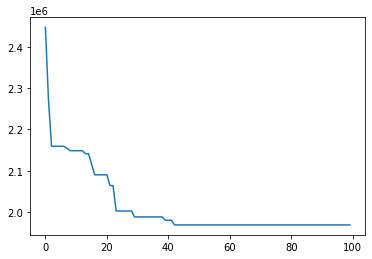

In [67]:
plt.plot(MinCost)

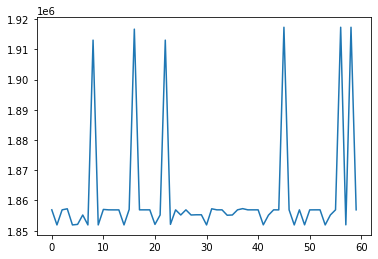

In [68]:
plt.plot(Cost)